In [16]:
# Importing the necessary libraries for AI2-THOR to run

!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab
import pickle
import os.path
import time
from typing import Dict, List

from ai2thor.controller import Controller
from ai2thor_colab import (
    plot_frames,
    show_objects_table,
    side_by_side,
    overlay,
    show_video
)

# Class for controlling robot navigation. This is where we will have all the navigation commands.
# This has NOT yet got the LLM connected, but merely a set of tools to move the robot and to interact
# with the simulation environment.
class RobotNavigationControl:
    is_DEBUG = False

    # Starts server
    def start_ai2_thor(self):
        ai2thor_colab.start_xserver()
        "AI2-THOR Version: " + ai2thor.__version__

    # Initialises controller
    def initialise_controller(self):
        self.controller = Controller(
            agentMode="default",
            visibilityDistance=1.5,
            scene="FloorPlan209",
            # image modalities
            #renderDepthImage=False,
            #renderInstanceSegmentation=False,
            # camera properties
            width=400,
            height=400,
            fieldOfView=120,
            # step sizes
            gridSize=0.25,
            snapToGrid=True,
            #rotateStepDegrees=15,
        )

        # If debug is enabled, then print scene name and a few other things.
        if (self.is_DEBUG):
            event = self.controller.step(action="RotateRight")
            metadata = event.metadata
            print(event, event.metadata.keys())
            print("sceneName : " + self.controller.last_event.metadata["sceneName"])
            #print("actionReturn : " + controller.last_event.metadata["actionReturn"])

    # Print a table of all objects in the scene
    def show_all_objects(self):
        show_objects_table(self.controller.last_event.metadata['objects'])
        print(self.controller.last_event.metadata['objects'])
    
    # Rotate left by given number of degrees degrees
    def rotate_left(self, deg):
        #event = controller.step("MoveBack")
        #plot_frames(controller.last_event)
        frames = []
        for _ in range(deg // 5):
            frames.append(self.controller.step(action="RotateLeft", degrees=5).frame)
            time.sleep(0.05)        
        
    # Store visible objects in the self.visible_objects collection and print them out if needed
    def get_visible_objects(self, print_objects = False):
        objects = self.controller.last_event.metadata['objects']
        visible_objects = []

        for obj in objects:
            if obj['visible']:
                if print_objects:
                    print(obj['objectType'] + " : " + str(obj['position']))
                visible_objects.append(obj)
                
        return visible_objects
        
    # Find the closest positon from the given reachable positions to the given object position using
    # Pythagorean theorem.
    def closest_position(self, object_position: Dict[str, float], reachable_positions: List[Dict[str, float]]) -> Dict[str, float]:
        out = reachable_positions[0]
        min_distance = float('inf')
        for pos in reachable_positions:
            # NOTE: y is the vertical direction, so only care about the x/z ground positions
            dist = sum([(pos[key] - object_position[key]) ** 2 for key in ["x", "z"]])
            if dist < min_distance:
                min_distance = dist
                out = pos
        return out
        
    # Navigate to object defined by the name in the input
    def navigate_to_object(self, obj_name):
        plot_frames(self.controller.last_event)
        visible_objs = self.get_visible_objects()
        
        obj_names = sorted([obj["objectType"] for obj in visible_objs])
        
        try:
            assert obj_name in obj_names
        except AssertionError:
            print(obj_name + " is not visible!!!!!!!!!!!!!!!!")
            return
        
        obj_navigate_to = next(obj for obj in visible_objs if obj["objectType"] == obj_name)
        
        #print(obj_navigate_to)
        
        reachable_positions = self.controller.step(action="GetReachablePositions").metadata["actionReturn"]
        
        pos_navigate_to = self.closest_position(obj_navigate_to['position'], reachable_positions)
        
        #print(pos_navigate_to)
        
        self.controller.step(action="Teleport", **pos_navigate_to)
        plot_frames(self.controller.last_event)

Vase2 is not visible!!!!!!!!!!!!!!!!
ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
RemoteControl : {'x': -4.292991638183594, 'y': 0.33039507269859314, 'z': -2.663956880569458}
Shelf : {'x': -2.475966215133667, 'y': 0.12455198913812637, 'z': -2.486457347869873}
Sofa : {'x': -4.3549981117248535, 'y': 0.00991678237915039, 'z': -2.089966058731079}
Vase : {'x': -2.6081905364990234, 'y': 0.579205334186554, 'z': -2.9408369064331055}


[{'name': 'ArmChair_3e286e7a',
  'position': {'x': -4.334003448486328,
   'y': 0.001995176076889038,
   'z': -3.5289852619171143},
  'rotation': {'x': -3.562221264491461e-12,
   'y': 90.00016784667969,
   'z': 2.4148366719600745e-06},
  'visible': True,
  'isInteractable': True,
  'receptacle': True,
  'toggleable': False,
  'isToggled': False,
  'breakable': False,
  'isBroken': False,
  'canFillWithLiquid': False,
  'isFilledWithLiquid': False,
  'fillLiquid': None,
  'dirtyable': False,
  'isDirty': False,
  'canBeUsedUp': False,
  'isUsedUp': False,
  'cookable': False,
  'isCooked': False,
  'temperature': 'RoomTemp',
  'isHeatSource': False,
  'isColdSource': False,
  'sliceable': False,
  'isSliced': False,
  'openable': False,
  'isOpen': False,
  'openness': 0.0,
  'pickupable': False,
  'isPickedUp': False,
  'moveable': True,
  'mass': 28.299999237060547,
  'salientMaterials': ['Fabric'],
  'receptacleObjectIds': ['KeyChain|-04.21|+00.32|-03.65'],
  'distance': 1.96077263355

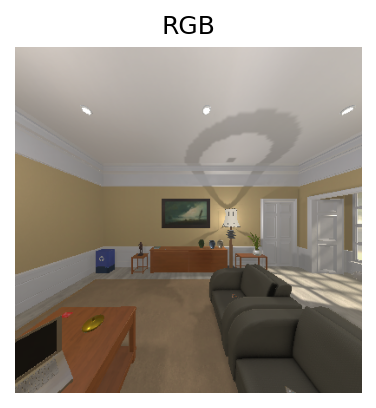

In [17]:
rnc = RobotNavigationControl()
rnc.start_ai2_thor()
rnc.initialise_controller()
rnc.rotate_left(180)
#rnc.get_visible_objects(True)
rnc.navigate_to_object("Vase")
#rnc.get_visible_objects(True)
